# U-Net for Brain MRI abnormally Segmentation

In this notebook, we will load the pre-trained U-Net model for brain MRI abnormally detection using PyTorch Hub. We are already familiar with PyTorch hub.

---

**U-Net with batch normalization for biomedical image segmentation with pretrained weights for abnormality segmentation in brain MRI**

<img src="https://pytorch.org/assets/images/unet_brain_mri.png" alt="alt" width="80%"/>

**<center>credits: mateuszbuda</center>**

---

Get more details of U-Net: Convolutional Networks for Biomedical Image Segmentation [here](https://arxiv.org/pdf/1505.04597.pdf)



In [1]:
%matplotlib inline

In [2]:
from torchvision import models
import torch
import torchvision.transforms as T

from PIL import Image
import matplotlib.pyplot as plt

import urllib

import numpy as np
import time
import glob
import os

## 1. Load the U-Net Model using PyTorch Hub

Loads a U-Net model pre-trained for abnormality segmentation. The model is traind on a dataset of brain MRI volumes [kaggle.com/mateuszbuda/lgg-mri-segmentation](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation). 

The Github repository where the model is hosted [here](https://github.com/mateuszbuda/brain-segmentation-pytorch).

### Model Description

- This U-Net model comprises four levels of blocks containing two convolutional layers with batch normalization and ReLU activation function, and one max pooling layer in the encoding part and up-convolutional layers instead in the decoding part.


- The number of convolutional filters in each block is 32, 64, 128, and 256. The buttleneck layer has 512 convolutional filters.


- From the encoding layers, skip connections are used to the corresponding layers in the decoding part.


- Input image is a 3-channel brain MRI slice from pre-contrast, FLAIR, and post-contrast sequences, respectively.


- Output is a one-channel probability map of abnormality regions with the same size as the input image.


- It can be transformed to a binary segmentation mask by thresholding the prediction output.


**Let's load the U-Net model.**

In [3]:
unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                      in_channels=3, out_channels=1, init_features=32, pretrained=True)


Using cache found in /home/ubuntu/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


## 2. Download a few barin MRI images

**[Download a few Sample MRI Images](https://www.dropbox.com/s/lgcmkj5zb97p1d9/mri-images.zip?dl=1)**

Download a few MRI images from [here](https://www.dropbox.com/s/lgcmkj5zb97p1d9/mri-images.zip?dl=1) and `unzip` it.

In [4]:
!wget https://www.dropbox.com/s/lgcmkj5zb97p1d9/mri-images.zip?dl=1 -O mri-images.zip
!unzip mri-images.zip -d ./
!rm mri-images.zip

--2020-04-17 23:35:29--  https://www.dropbox.com/s/lgcmkj5zb97p1d9/mri-images.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6017:1::a27d:201, 162.125.2.1
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6017:1::a27d:201|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/lgcmkj5zb97p1d9/mri-images.zip [following]
--2020-04-17 23:35:29--  https://www.dropbox.com/s/dl/lgcmkj5zb97p1d9/mri-images.zip
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7221c9f505d3605dc96b768602.dl.dropboxusercontent.com/cd/0/get/A2G7uWwH-XZwv58_PhTL4PTHyooIwOkdrC5UTdzhzGByAshnikDC3en1mfXlj5i-gjdowqU1LD7Xn8lDDgmD1QqdEo3m6KGeaJHXtfmDkGUaHyB_UJD624a0DVUcXdXSKfw/file?dl=1# [following]
--2020-04-17 23:35:30--  https://uc7221c9f505d3605dc96b768602.dl.dropboxusercontent.com/cd/0/get/A2G7uWwH-XZwv58_PhTL4PTHyooIwOkdrC5UTdzhzGByAshnikDC3en1mfXlj5i-gjdowqU1LD7Xn8lDDgmD1QqdEo

**This function will gve the list of all downloaded images.**

In [5]:
def get_images_and_mask_images(root='mri-images'):
    mask_images = glob.glob(os.path.join(root, '*_mask.tif'))
    
    images = []
    
    for m_img in mask_images:
        ind = m_img.find('_mask.tif')
        image_path = m_img[:ind] + '.tif'
        images.append((image_path, m_img))
    return images
    

In [6]:
images = get_images_and_mask_images()

for img_tuple in images:
    print('{}\t{}'.format(img_tuple[0], img_tuple[1]))

mri-images/TCGA_CS_4944_20010208_7.tif	mri-images/TCGA_CS_4944_20010208_7_mask.tif
mri-images/TCGA_DU_5855_19951217_16.tif	mri-images/TCGA_DU_5855_19951217_16_mask.tif
mri-images/TCGA_DU_7014_19860618_26.tif	mri-images/TCGA_DU_7014_19860618_26_mask.tif
mri-images/TCGA_CS_4944_20010208_12.tif	mri-images/TCGA_CS_4944_20010208_12_mask.tif
mri-images/TCGA_DU_5855_19951217_14.tif	mri-images/TCGA_DU_5855_19951217_14_mask.tif


## 3. Inference Pipeline

**Load the image.**

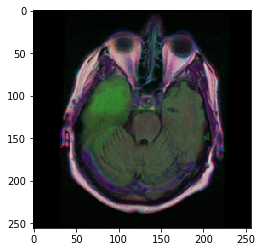

Mask image (ground truth)


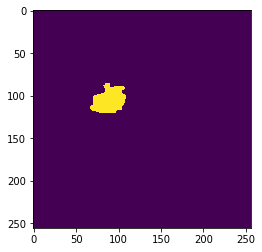

In [7]:
img = Image.open(images[0][0]).convert("RGB")
plt.imshow(img) 
plt.show()

print('Mask image (ground truth)')
mask_img = Image.open(images[0][1])
plt.imshow(mask_img) 
plt.show()


In [8]:
# the cuda device name
cuda_device = 'cuda:0'

**Let's do inference on the loded image.**

In [9]:
# pre-procees the input image
preprocess = T.Compose([ T.ToTensor(),])

# preprocess
input_tensor = preprocess(img)

# prepare as batch
input_batch = input_tensor.unsqueeze(0)

# check if cuda is available if true use the specified cuda/GPU
if torch.cuda.is_available():
    input_batch = input_batch.to(cuda_device)
    unet = unet.to(cuda_device)

# Infer the model
with torch.no_grad():
    output = unet(input_batch)

# rounding the out will give 1 if value > 0.5.
# One can use threshold other than 0.5
pred = torch.round(output[0]).squeeze().detach().cpu().numpy()

**Let's convert predection as an image.**

Prediction


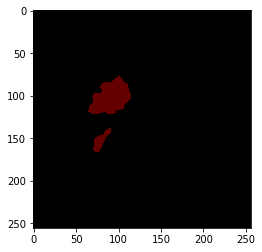

In [10]:
# Conver prediction as 3-channel image
r = np.zeros_like(pred).astype(np.uint8)
g = np.zeros_like(pred).astype(np.uint8)
b = np.zeros_like(pred).astype(np.uint8)

# Get all index that have value 1
idx = pred == 1

# update index of r-channel with value 100
# one may update with other value. Even one can update other channels also.
r[idx] = 100

# stact to form an image
pred_img = np.stack([r, g, b], axis=2)

print('Prediction')
plt.imshow(pred_img)
plt.show()

**We are combining the inference pipeline in a function.**

In [11]:
def brain_mri_abnormally_detection(model, img_path, mask_path, cuda_device=None):
    """
    This function will take model, input image path, mask image path, and cuda_device
    and plot image, mask and prediction mask
    
    parameters:
    
    model (nn.module): model, e.g. U-Net
    img_path (str): Input image path
    mask_path (str): mask image path (ground truth)
    cuda_device (str): cuda device name, e.g. cuda, cuda:0, cuda:2
    
    
    """
    
    plt.rcParams["figure.figsize"] = (15, 5)
    plt.figure
    img = Image.open(img_path).convert("RGB")
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.gca().set_title('Input Image')
    plt.axis('off')
    
    mask_img = Image.open(mask_path).convert("RGB")
    plt.subplot(1, 3, 2)
    plt.imshow(mask_img)
    plt.gca().set_title('Mask (G-truth)')
    plt.axis('off')
    
    input_tensor = preprocess(img)

    input_batch = input_tensor.unsqueeze(0)

    if torch.cuda.is_available():
        input_batch = input_batch.to(cuda_device)
        model = model.to(cuda_device)

    with torch.no_grad():
        output = unet(input_batch)

    # rounding the out will give 1 if value > 0.5
    pred = torch.round(output[0]).squeeze().detach().cpu().numpy()
    
    r = np.zeros_like(pred).astype(np.uint8)
    g = np.zeros_like(pred).astype(np.uint8)
    b = np.zeros_like(pred).astype(np.uint8)

    idx = pred == 1
    r[idx] = 100
    pred_img = np.stack([r, g, b], axis=2)
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_img)
    plt.gca().set_title('Pred Segments')
    plt.axis('off')
    plt.show()
    
    return
    

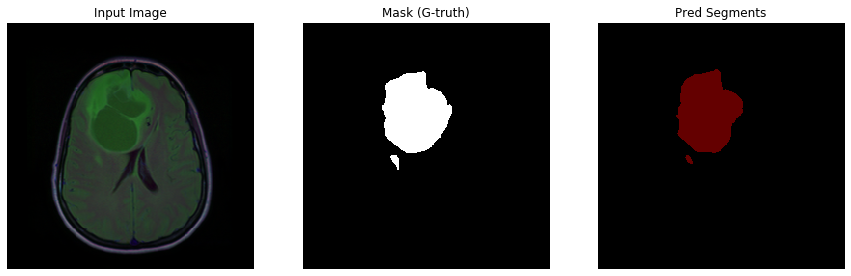

In [12]:
brain_mri_abnormally_detection(unet, images[1][0], images[1][1], cuda_device)

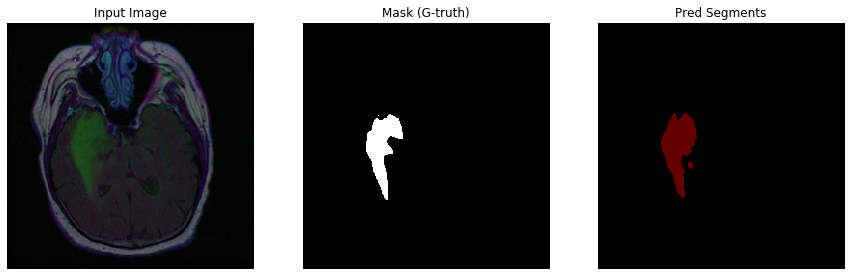

In [13]:
brain_mri_abnormally_detection(unet, images[2][0], images[2][1], cuda_device)

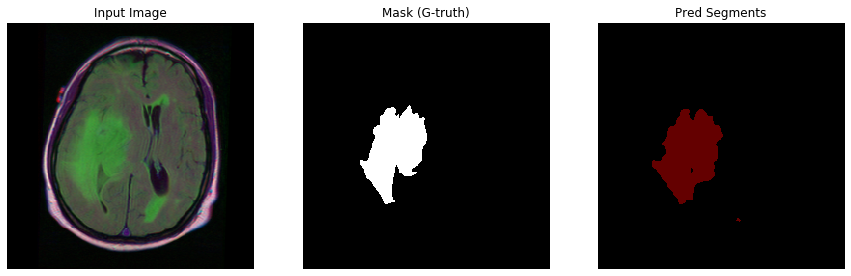

In [14]:
brain_mri_abnormally_detection(unet, images[3][0], images[3][1], cuda_device)

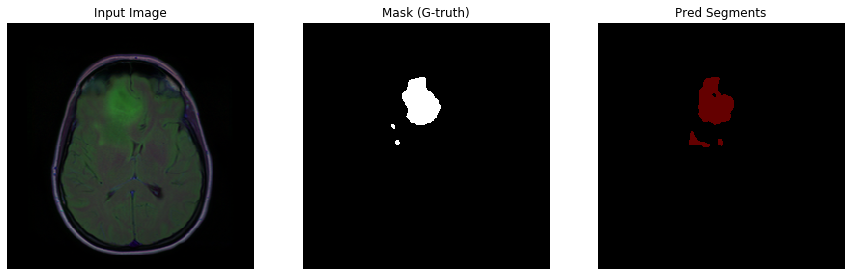

In [15]:
brain_mri_abnormally_detection(unet, images[4][0], images[4][1], cuda_device)

# Reference


- [Brain Segmentation PyTorch U-Net](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)


- [Brain Segmentation PyTorch Github](https://github.com/mateuszbuda/brain-segmentation-pytorch)


- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)


- [Brain MRI segmentation dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation)